### Mounting your google drive on Colab Noetebook

In [23]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 
datapath = './data/VariantEffectPrediction/clinvarHC_modeling.csv.gz'

In [ ]:
#%cd ../

In [3]:
import src.utility_functions as uf   ## cargo funciones
# data manipulation
import pandas as pd
import numpy as np
from operator import itemgetter


## learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

## preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


### model performance
from sklearn import metrics

#ploting modules
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


## además cargo funciones específicas para este notebook
try:
    import category_encoders as ce
except:
    !pip install category_encoders


from sklearn.model_selection import cross_val_score

## Para guardar y levantar un objeto en pickle (ej. resultados de un gridsearch intensivo)
import joblib as jlb


## Hyperparameter optimization
from sklearn.model_selection import GridSearchCV
try:
    from skopt import BayesSearchCV
except: 
    !pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# para optimizar vía gaussian process (secuencial). 
from skopt import gp_minimize
from skopt.utils import use_named_args
# para visualizar el gp secuencial
from skopt import plots as skplots


try:
    import shap
except:
    !pip install shap
    import shap




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Processing /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac/shap-0.35.0-cp36-cp36m-linux_x86_64.whl


In [4]:
# Load data and define preprocessing
SEED = 2718281
targetcolumn = 'ClinvarHC'

## esto asume que estas parado ya en la carpeta ppal del repositorio
data = pd.read_csv(datapath,sep = ',',index_col='ChrPosRefAlt')
X,y = data.drop([targetcolumn],axis = 1), data[[targetcolumn]]

## train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=SEED,stratify = y)
Y_train = y_train[targetcolumn].ravel()
Y_test = y_test[targetcolumn].ravel()

categorical_feature_mask = X_train.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X_train.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
numerical_columns = X_train.columns[~X_train.columns.isin(categorical_columns)].tolist() # defino las numéricas como el complemento de las categóricas 


numerical_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))])  # Esto es una vacancia de Sklearn, no permite aún "centrar" matrizes sparse


categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])      


preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer,numerical_columns),
    ('cat', categorical_transformer,categorical_columns)
])


In [5]:
print(X.shape)
print(X_train.shape, X_test.shape)


(1407, 34)
(703, 34) (704, 34)


### Target encoding

In [6]:
?DecisionTreeClassifier

In [7]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',DecisionTreeClassifier(random_state = SEED))])  


In [8]:
res= cross_val_score(pipeline, X_train, Y_train, cv=5,scoring = 'average_precision')
print(np.mean(res),np.std(res))

0.53752748139967 0.0656701037428048


## Explorarción de hiperparámetros
Acá les dejo algo de lectura online:

__[Acá, explicado cada hyperp](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)__  


## Pueden ver otro notebook online de tuneado individual de parámetros ###
__[Acá, exploración individual](https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3)__


##### Básicamente tenemos:

* ***Max number of features***

* ***Criterion*** Métrica para medir la impuresa: Gini impurity ó Entropía.

* ***Spliter*** Nos da la opción de elegir el mejor split en cada rama,  ó de aleatorizar ese proceso (random). 



*** Hyperparámetros de pre-pruning*** (early stopping)

###### pre-prunning a nivel global del árbol
* ***Max Depth*** Máxima profundidad del árbol

* ***Max Leaf Nodes*** Máximo número de nodos

* ***min Samples of leaf *** Número (o fracción) mínima para una hoja del árbol.

* ***min weight fraction leaf*** Idem anterior pero considerando pesos de cada ítem a clasificar.

###### A nivel de nodo
* ***min Samples Split*** número mínimo de muestras que debe haber para generar un nuevo nodo. 

* ***min Impurity decrease*** Umbral mínimo para el decrecimiento de la impureza necesario para generar un nuevo nodo




##### el pre-pruning corre riesgo de una detención prematura del árbol, pero cuando lo ejecutamos de la mano de validación cruzada ese riesgo se reduce (a menos que nos quedemos corto con el espacio de parámetros considerado) 


***ccp_alpha*** Parámetro de complejidad para el post pruning 
### Lectura (práctica) básica de referencia 
* __[post_pruning_cost_complexity](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)_
* Ojo, post pruning no asegura buena generalización, pues se prunean nodos de 

### Veamos los parámetros por defecto del árbol

In [9]:
pipeline.named_steps['clasificador']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2718281, splitter='best')

### Analizemos cómo impacta la máxima profundiad del arbol admitida (Max Depth)

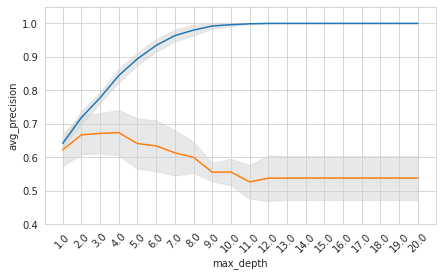

In [10]:
name = 'max_depth'
value_range = np.linspace(1, 20, 20, endpoint=True)

## defino grilla
gridname = 'clasificador__%s'%name
param_grid = [
  {gridname:value_range}
 ]


search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

matplotlib.rcParams['figure.figsize'] = [7, 4]
uf.my_train_test_plot(gridsearch=search,grid=param_grid,hyp=name,ylim = [0.4,1.05], ylabel= 'avg_precision')


### Ya que vamos a explorar bastante, les puse un atajo empaquetado en utility functions que le pasan:
* pipe: el pipeline
* hyp: el nombre del hyperparámetro que quieren mirar
* range: el rango donde quieren mirar


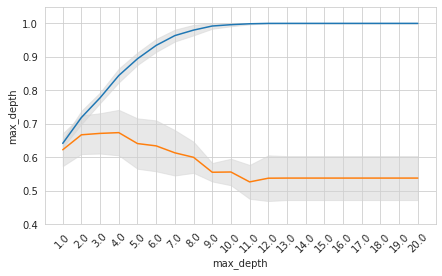

In [11]:
#pipeline.named_steps['clasificador'].set_params(**{'splitter':'random'})
#pipeline.named_steps['clasificador'].set_params(**{'criterion':'entropy'})
uf.univariate_exploring(pipeline,X= X_train,Y = Y_train,hyp='max_depth', 
                        range = np.linspace(1, 20, 20, endpoint=True),
                        cv = 5,ylim = [0.4,1.05])

### Veamos el efecto que tiene el threshold que fijamos a uno nodo (en número de muestras) para que pueda ser dividido (Min samples split)

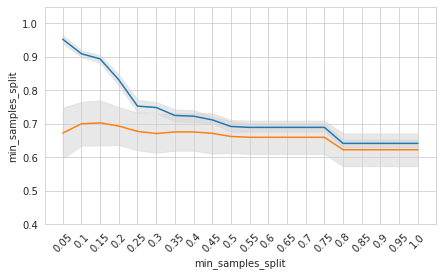

In [12]:
uf.univariate_exploring(pipeline,X= X_train, Y = Y_train, hyp = 'min_samples_split', 
                     range = np.linspace(0.05, 1.0, 20, endpoint=True)
                     ,ylim = [0.4,1.05])

### GridSearch

In [13]:
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',DecisionTreeClassifier(random_state = SEED))]) 

max_depths = np.linspace(3, 7, 5, endpoint=True)
min_samples_splits = np.linspace(0.05, 0.2, 5, endpoint=True)
max_features= np.linspace(0.15, 0.6, 5, endpoint=True)
min_samples_leafs = np.linspace(0.01, 0.2, 5, endpoint=True)
#min_impurity_decrease = np.linspace(0,0.01, 5, endpoint=True)

param_grid = [
  {
      'clasificador__max_depth':max_depths,
      'clasificador__min_samples_split':min_samples_splits,
      'clasificador__max_features':max_features,
      'clasificador__min_samples_leaf':min_samples_leafs
#      'clasificador__min_impurity_decrease':min_impurity_decrease
  }
 ]
search = GridSearchCV(pipeline, param_grid, 
                      cv=10,return_train_score = True,
                     scoring = 'average_precision').fit(X_train, Y_train)

#jlb.dump(search, 'DecisionTree.pkl')                           ### Para guardar el modelo
#my_train_test_plot(search,param_grid,'min_samples_leaf')

In [14]:
print('performance best classif %.4f'%search.best_score_)
print('best hyperparameters: \n')

search.best_params_

performance best classif 0.7940
best hyperparameters: 



{'clasificador__max_depth': 6.0,
 'clasificador__max_features': 0.6,
 'clasificador__min_samples_leaf': 0.01,
 'clasificador__min_samples_split': 0.16250000000000003}

In [15]:
## para ver la varianza que tuvo tengo que volver a entrenar via Kfold
aux= cross_val_score(search.best_estimator_, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(aux),np.std(aux))

0.7940279422315922 0.07822727236875665


In [16]:
# en el test? 
metrics.average_precision_score(Y_test,search.best_estimator_.predict_proba(X_test)[:,1])

0.6743769143306211

### Veamos, movimos 4 hyperparámetros, en 5 puntos cada uno. Osea corrimos 5^4 = 625 iteraciones (x 5 si considerás el 5FoldValid)! 
*  Estamos invirtiendo bien el tiempo de entrenamiento? 
*  Qué otra forma un poco más inteligente podemos usar para explorar?
*  Si nos movemos random? por la grilla? o random en los intervalos de búsqueda planteados?
*  Seguimos sobreajustando!! 

## Y en un solo paso... La magia del ensemble. La sabiduría de las masas

In [17]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline(steps = [('preprocessing',preprocessor),
                             ('clasificador',RandomForestClassifier(random_state = SEED,n_estimators=500))])  

res= cross_val_score(pipeline, X_train, Y_train, cv=10,scoring = 'average_precision')
print(np.mean(res),np.std(res))

0.886948535698169 0.059997965119361805


In [18]:
pipeline.fit(X_train,Y_train)
ypred_test = pipeline.predict_proba(X_test)[:,1]
metrics.average_precision_score(Y_test,ypred_test)

0.8381097026969974

## Nuestro random Forest sin ajustarle ni un solo hiperparámetro:
* aplastó al decision tree
* Mejoró el resultadodo de una LR?
* Si hubo tal mejora es estadísticamente significativa o es ruido?


## Guardemos el modelo

In [19]:
res = y_test.copy()
res['y_pred'] = ypred_test
res.to_csv('./models/RF_wholedata_testing_set.tsv',sep = '\t')


## Ploteando el feature Imporance del RF

In [20]:
numerical_names = pipeline.named_steps['preprocessing'].transformers[0][2]
categorical_output_names = pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()

cols = numerical_names + categorical_output_names 

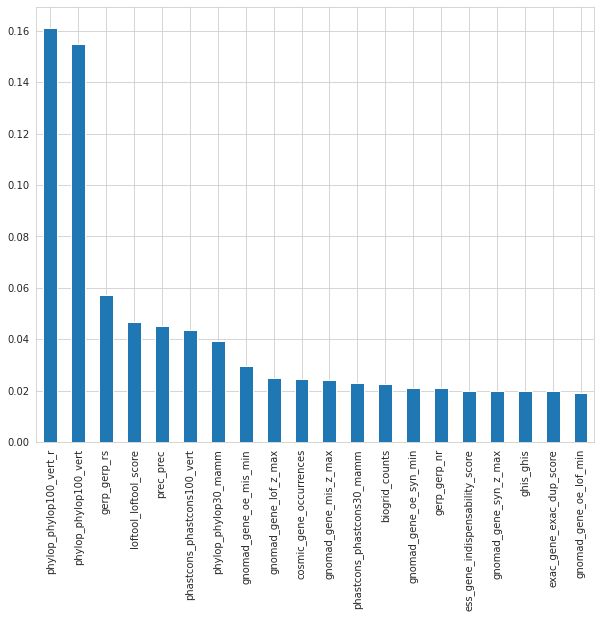

In [21]:
matplotlib.rcParams['figure.figsize'] = [10, 8]
clf = pipeline.named_steps['clasificador']
fi = pd.Series(clf.feature_importances_,index = cols )
fi.sort_values(ascending=False)[0:20].plot(kind = 'bar')


### Ojo con la interpretacion del feature importance!

* Aparecen features correlacionados?
